In [29]:
import numpy as np
import pandas as pd
import random
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Normal, Categorical
from IPython.display import clear_output

In [30]:
def get_gae(
    rewards: list,
    values: list,
    is_terminals: list,
    gamma: float,
    lamda: float,
    ):
    """
    Takes: lists of rewards, state values, and 1-dones.
    Returns: list with generalized adversarial estimators.
    More details - https://arxiv.org/pdf/1506.02438.pdf.
    """
    gae = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = (rewards[i] + gamma * values[i + 1] * is_terminals[i] - values[i])
        gae = delta + gamma * lamda * is_terminals[i] * gae
        returns.insert(0, gae + values[i])

    return returns

def trajectories_data_generator(
    states: torch.Tensor,
    actions: torch.Tensor,
    returns: torch.Tensor,
    log_probs: torch.Tensor,
    values: torch.Tensor,
    advantages: torch.Tensor,
    batch_size,
    num_epochs,
    ):
    """data-generator."""
    data_len = states.size(0)
    for _ in range(num_epochs):
        for _ in range(data_len // batch_size):
            ids = np.random.choice(data_len, batch_size)
            yield states[ids, :], actions[ids], returns[ids], log_probs[ids], values[ids], advantages[ids]

In [31]:
class ContinuousActor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
    ):
        """Initialize."""
        super(ContinuousActor, self).__init__()

        self.hidden = nn.Linear(in_dim, 32)
        self.mu_layer = nn.Linear(32, out_dim)
        self.log_std_layer = nn.Linear(32, out_dim)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))
        
        mu = torch.tanh(self.mu_layer(x))
        log_std = torch.tanh(self.log_std_layer(x))

        std = torch.exp(log_std)
        dist = Normal(mu, std)
        action = dist.sample()

        return action, dist


class DiscreteActor(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int
        ):
        """Initialize."""
        super(DiscreteActor, self).__init__()
        self.hidden1 = nn.Linear(in_dim, 32)
        self.hidden2 = nn.Linear(32, out_dim)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.relu(self.hidden1(state))
        x = self.hidden2(x)
        probs = F.softmax(x, dim=1)

        dist = Categorical(probs)
        action = dist.sample()
        return action, dist
        
        
class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden = nn.Linear(in_dim, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))
        value = self.out(x)

        return value

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv2d):
        nn.init.orthogonal_(m.weight.data, np.sqrt(float(2)))
        if m.bias is not None:
            m.bias.data.fill_(0)

In [32]:
class Memory:
    """Storing the memory of the trajectory (s, a, r ...)."""
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.is_terminals = []
        self.log_probs = []
        self.values = []

    def clear_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.is_terminals = []
        self.log_probs = []
        self.values = []
        
        
class PPOAgent(object):
    """PPOAgent.
    Parameters:
        device: cpu or gpu acelator.
        make_env: factory that produce environment.
        continuous: True of environments with continuous action space.
        obs_dim: dimension od observaion.
        act_dim: dimension of action.
        gamma: coef for discount factor.
        lamda: coef for general adversial estimator (GAE).
        entropy_coef: coef of weighting entropy in objective loss.
        epsilon: clipping range for actor objective loss.
        actor_lr: learnig rate for actor optimizer.
        critic_lr: learnig rate for critic optimizer.
        value_range: clipping range for critic objective loss.
        rollout_len: num t-steps per one rollout.
        total_rollouts: num rollouts.
        num_epochs: num weights updation iteration for one policy update.
        batch_size: data batch size for weights updating
        actor: model for predction action.
        critic: model for prediction state values.
        plot_interval: interval for plotting train history.
        solved_reward: desired reward.
        plot_interval: plot history log every plot_interval rollouts.
        path2save_train_history: path to save training history logs.
        """
    def __init__(
        self,
        make_env,
        continuous: bool,
        obs_dim: int,
        act_dim: int,
        gamma: float,
        lamda: float,
        entropy_coef: float,
        epsilon: float,
        value_range: float,
        rollout_len: int,
        total_rollouts: int,
        num_epochs: int,
        batch_size: int,
        is_evaluate: bool,
        path2save_train_history: str,
        plot_interval: int = 10,
        solved_reward: int = None,
        actor_lr: float = 0.001,
        critic_lr:float = 0.001 
        ):
        """
        Initialization.
        """
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        print("device:", self.device)
        self.env = make_env()

        # coeffs
        self.gamma = gamma
        self.lamda = lamda
        self.entropy_coef = entropy_coef
        self.epsilon = epsilon
        self.value_range = value_range
        
        # other hyperparameters
        self.rollout_len = rollout_len
        self.total_rollouts = total_rollouts
        self.num_epochs = num_epochs
        self.batch_size = batch_size

        # agent nets
        self.obs_dim = obs_dim

        if continuous:
            self.actor = ContinuousActor(self.obs_dim, act_dim).apply(
                init_weights).to(self.device)
        else:
            self.actor = DiscreteActor(self.obs_dim, act_dim).apply(
                init_weights).to(self.device)

        self.critic = Critic(self.obs_dim).apply(init_weights).to(self.device)

        # agent nets optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        # memory of trajectory (s, a, r ...)
        self.memory = Memory()

        # memory of the train history
        self.actor_loss_history = []
        self.critic_loss_history = []
        self.scores = []

        self.is_evaluate = is_evaluate
        self.solved_reward = solved_reward
        self.plot_interval = plot_interval
        self.path2save_train_history = path2save_train_history

    def _get_action(self, state: np.ndarray) -> float:
        """
        Get action from actor, and if not test -  
        get state value from critic, collect elements of trajectory.
        """
        state = torch.FloatTensor(state).to(self.device)
        action, dist = self.actor(state)

        if not self.is_evaluate:
            value = self.critic(state)
           
            # collect elements of trajectory
            self.memory.states.append(state)
            self.memory.actions.append(action)
            self.memory.log_probs.append(dist.log_prob(action))
            self.memory.values.append(value)

        return list(action.detach().cpu().numpy()).pop()
            
    def _step(self, action: float):
        """
        Make action in enviroment chosen by current policy,
        if not evaluate - collect elements of trajectory.
        """
        #print(action)
        next_state, reward, done, _ = self.env.step(action)

        # add fake dim to match dimension with batch size
        next_state = np.reshape(next_state, (1, -1)).astype(np.float64)
        reward = np.reshape(reward, (1, -1)).astype(np.float64)
        done = np.reshape(done, (1, -1))

        if not self.is_evaluate:
            # convert np.ndarray return from enviroment to torch tensor. 
            # collect elements of trajectory.
            self.memory.rewards.append(torch.FloatTensor(reward).to(self.device))
            self.memory.is_terminals.append(torch.FloatTensor(1 - done).to(self.device))

        return next_state, reward, done

    def train(self):
        """
        Interaction process in enviroment for collect trajectory,
        train process by agent nets after each rollout.
        """
        score = 0
        state = self.env.reset()
        state = np.reshape(state, (1, -1))

        for step_ in range(self.total_rollouts):
            for _ in range(self.rollout_len):
                action = self._get_action(state)
                next_state, reward, done = self._step(action)

                state = next_state
                score += reward[0][0]

                if done[0][0]:
                    self.scores.append(score)
                    score = 0
                    state = self.env.reset()
                    state = np.reshape(state, (1, -1))

            if (step_ % self.plot_interval == 0):
                self._plot_train_history()

            # if we have achieved the desired score - stop the process.
            if self.solved_reward is not None:
                if np.mean(self.scores[-10:]) > self.solved_reward:
                    print("Congratulations, it's solved!")
                    break

            value = self.critic(torch.FloatTensor(next_state))
            self.memory.values.append(value)
            # update policy
            self._update_weights()

        # self._save_train_history()
        self.env.close()

    def _update_weights(self):

        returns = get_gae(
            self.memory.rewards,
            self.memory.values,
            self.memory.is_terminals,
            self.gamma,
            self.lamda,
        )
        actor_losses, critic_losses = [], []

        # flattening a list of torch.tensors into vectors
        states = torch.cat(self.memory.states).view(-1, self.obs_dim)
        actions = torch.cat(self.memory.actions)
        returns = torch.cat(returns).detach()
        log_probs = torch.cat(self.memory.log_probs).detach()
        values = torch.cat(self.memory.values).detach()
        advantages = returns - values[:-1]

        for state, action, return_, old_log_prob, old_value, advantage in trajectories_data_generator(
            states=states,
            actions=actions,
            returns=returns,
            log_probs=log_probs,
            values=values,
            advantages=advantages,
            batch_size=self.batch_size,
            num_epochs=self.num_epochs,
            ):

            # compute ratio (pi_theta / pi_theta__old)
            _, dist = self.actor(state)
            cur_log_prob = dist.log_prob(action)
            ratio = torch.exp(cur_log_prob - old_log_prob)

            # compute entropy
            entropy = dist.entropy().mean()

            # compute actor loss
            loss =  advantage * ratio
            clipped_loss = (
                torch.clamp(ratio, 1. - self.epsilon, 1. + self.epsilon)
                 * advantage
                )
            actor_loss = (
                -torch.mean(torch.min(loss, clipped_loss))
                - entropy * self.entropy_coef)
            
            # critic loss, uncoment for clipped value loss too.
            cur_value = self.critic(state)
            #clipped_value = (
            #    old_value + torch.clamp(cur_value - old_value,
            #                            -self.value_range, self.value_range)
            #   )
            #loss = (return_ - cur_value).pow(2)
            #clipped_loss = (return_ - clipped_value).pow(2)
            #critic_loss = torch.mean(torch.max(loss, clipped_loss))

            critic_loss = (return_ - cur_value).pow(2).mean()

            # actor optimizer step
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # critic optimizer step
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())

        # clean memory of trajectory
        self.memory.clear_memory()

        # write mean losses in train history logs
        actor_loss = sum(actor_losses) / len(actor_losses)
        critic_loss = sum(critic_losses) / len(critic_losses)
        self.actor_loss_history.append(actor_loss)
        self.critic_loss_history.append(critic_loss)

    def _plot_train_history(self):
        data = [self.scores, self.actor_loss_history, self.critic_loss_history]
        labels = [f"mean of last 10 scores {np.mean(self.scores[-10:])}",
                  f"actor loss {np.mean(self.actor_loss_history[-10:])}", 
                  f"critic loss {np.mean(self.critic_loss_history[-10:])}",
                  ]

        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(6, 8))
            for i, ax in enumerate(axes):
                ax.plot(data[i], c="crimson")
                ax.set_title(labels[i])
                if (i == 0):
                    ax.axhline(y = 200, color = 'g', linestyle = '-')
                    ax.axhline(y = 0, color = 'r', linestyle = '-')

            plt.tight_layout()
            plt.show()

    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.actor.state_dict(),
                   f"{self.path2save_train_history}/actor.pth")
        torch.save(self.critic.state_dict(),
                   f"{self.path2save_train_history}/critic.pth")
        
        pd.DataFrame({"actor loss": self.actor_loss_history, 
                      "critic loss": self.critic_loss_history}
                     ).to_csv("loss_logs.csv")

        pd.DataFrame(
            data=self.scores, columns=["scores"]
            ).to_csv("score_logs.csv")   
        
    def evaluate(self):
        self.is_evaluate = True
        
        state = self.env.reset()
        state = np.reshape(state, (1, -1))
        done = False

        for _ in range(self.rollout_len):
            while not done:
                action = self._get_action(state)
                next_state, reward, done = self._step(action)

                state = next_state
                state = np.reshape(state, (1, -1))

            self.env.close()

    def load_predtrain_model(self,
                             actor_weights_path: str,
                             critic_weights_path: str):

        self.actor.load_state_dict(torch.load(actor_weights_path))
        self.critic.load_state_dict(torch.load(critic_weights_path))
        print("Predtrain models loaded")

In [33]:
class GlobalConfig:
    def __init__(self):
        self.seed = 555
        self.path2save_train_history = "/content/"

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

config = GlobalConfig()
seed_everything(config.seed)

def make_env():
    # environment
    env_id = "LunarLanderContinuous-v2"
    env = gym.make(env_id)
    env.seed(config.seed)
    return env 

In [34]:
"""    
    Parameters:
    device: cpu or gpu acelator.
    make_env: factory that produce environment.
    continuous: True of environments with continuous action space.
    obs_dim: dimension od observaion.
    act_dim: dimension of action.
    gamma: coef for discount factor.
    lamda: coef for general adversial estimator (GAE).
    entropy_coef: coef of weighting entropy in objective loss.
    epsilon: clipping range for actor objective loss.
    actor_lr: learnig rate for actor optimizer.
    critic_lr: learnig rate for critic optimizer.
    value_range: clipping range for critic objective loss.
    rollout_len: num t-steps per one rollout.
    total_rollouts: num rollouts.
    num_epochs: num weights updation iteration for one policy update.
    batch_size: data batch size for weights updating
    actor: model for predction action.
    critic: model for prediction state values.
    plot_interval: interval for plotting train history.
    solved_reward: desired reward.
    plot_interval: plot history log every plot_interval rollouts.
    path2save_train_history: path to save training history logs.
"""
agent = PPOAgent(
    make_env,
    obs_dim = 8,
    act_dim = 2,
    gamma = 0.99,
    lamda = 0.95,
    entropy_coef = 0.02,
    epsilon = 0.2,
    value_range = 0.5,
    rollout_len = 1000,
    total_rollouts = 1000,
    num_epochs = 10,
    batch_size = 64,
    is_evaluate = False,
    continuous = True,
    solved_reward = 200,
    path2save_train_history = config.path2save_train_history,
)

device: cpu


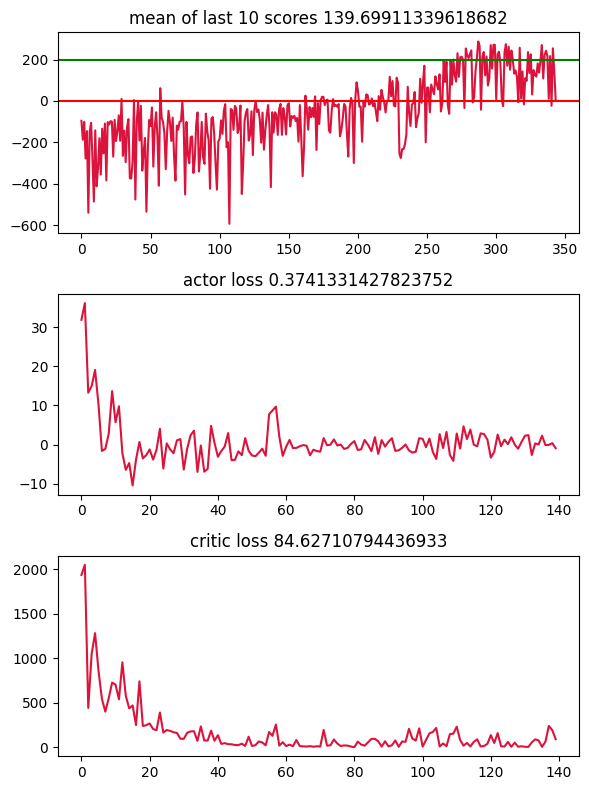

Congratulations, it's solved!
CPU times: total: 11min 35s
Wall time: 4min 55s


In [35]:
%%time
agent.train()
#solved when the average of the last 10 score is greater or equal to 200